In [47]:
!pip install -q diffusers transformers accelerate scipy safetensors gradio

In [48]:
import torch
from diffusers import StableDiffusionInpaintPipeline

In [49]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [50]:
pipe.to("cuda")

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.30.1",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [51]:
from PIL import Image
import requests
from io import BytesIO

def load_image_from_url(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  return image


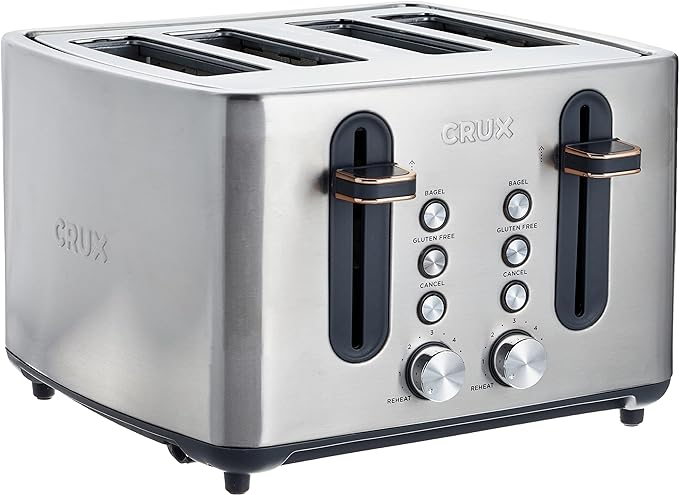

In [52]:
import requests
from PIL import Image
from io import BytesIO

def download_image_from_drive(drive_url):
    # Extract the file ID from the URL
    file_id = drive_url.split('/')[-2]

    # Create the direct download URL
    download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

    # Send a GET request to download the file
    response = requests.get(download_url)
    response.raise_for_status()  # Check if the request was successful

    # Open the image using PIL
    image = Image.open(BytesIO(response.content))

    return image

# Example usage
drive_url = "https://drive.google.com/file/d/1ZNHcgKfuqom8S3fk0OisM2AaHwjViVQG/view?usp=sharing"
image = download_image_from_drive(drive_url)

# Display the image
image


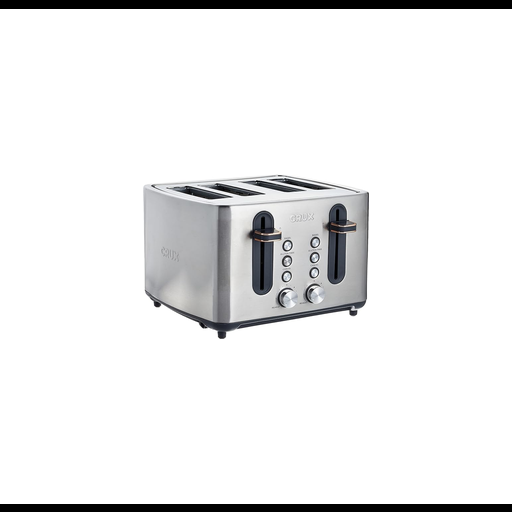

In [59]:
from PIL import Image

def zoom_out_any_size(image, n):
    # Original dimensions
    original_width, original_height = image.size

    # Calculate new dimensions after shrinking
    new_width = int(original_width // n)
    new_height = int(original_height // n)
    print(new_width,new_height)
    # Resize the image (shrink the object)
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    # Create a new white canvas that is n times larger than the original
    new_canvas_width = original_width
    new_canvas_height = original_height
    new_image = Image.new("RGB", (new_canvas_width, new_canvas_height), "white")

    # Calculate the position to paste the resized object in the center
    x_offset = (new_canvas_width - new_width) // 2
    y_offset = (new_canvas_height - new_height) // 2

    # Paste the resized image onto the center of the new canvas
    new_image.paste(resized_image, (x_offset, y_offset))
    return new_image

def zoom_out(image, n):
    # Original dimensions
    original_width, original_height = image.size

    # Calculate new dimensions after shrinking
    new_width = int(original_width // n)
    new_height = int(original_height // n)

    # Resize the image (shrink the object)
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new white canvas that is the same size as the original image
    new_image = Image.new("RGB", (original_width, original_height), "white")

    # Calculate the position to paste the resized object in the center
    x_offset = (original_width - new_width) // 2
    y_offset = (original_height - new_height) // 2

    # Paste the resized image onto the center of the new canvas
    new_image.paste(resized_image, (x_offset, y_offset))

    # Calculate coordinates to crop the central 512x512 area
    left = (original_width - 512) // 2
    top = (original_height - 512) // 2
    right = left + 512
    bottom = top + 512

    # Crop the center 512x512 region
    final_image = new_image.crop((left, top, right, bottom))

    return final_image

image_big = zoom_out(image, 3)
display(image_big)

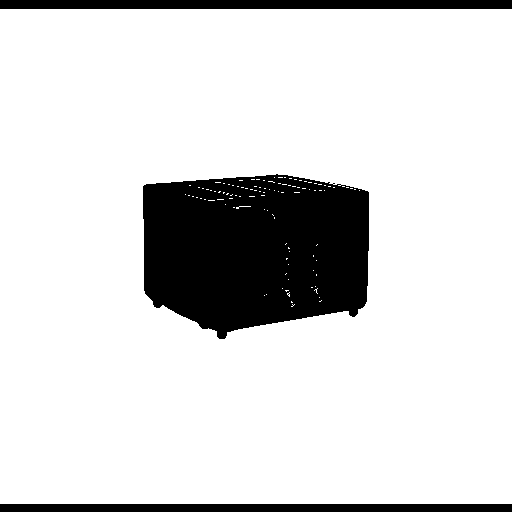

In [60]:
def create_mask(image, tolerance=20):
    # Convert the image to a numpy array
    image_array = np.array(image)

    # Define a tolerance range around white
    lower_bound = np.array([255 - tolerance] * 3)
    upper_bound = np.array([255] * 3)

    # Create a mask: white for white pixels, black for non-white
    mask = np.ones((image_array.shape[0], image_array.shape[1]), dtype=np.uint8) * 255
    non_white_pixels = np.any((image_array < lower_bound) | (image_array > upper_bound), axis=-1)
    mask[non_white_pixels] = 0  # Non-white pixels become black in the mask

    # Convert mask to PIL Image
    mask_image = Image.fromarray(mask)

    return mask_image


mask = create_mask(image_big,tolerance=10)

display(mask)

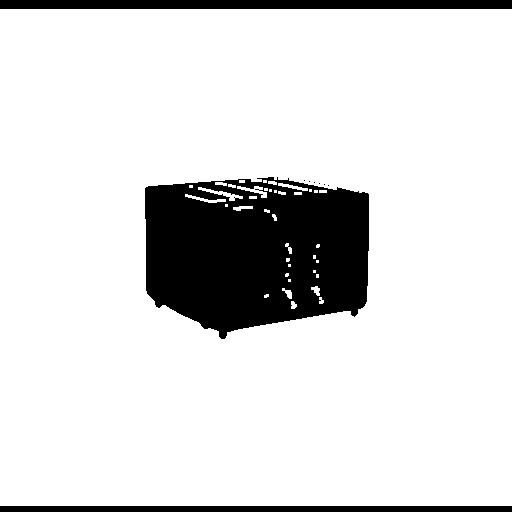

In [61]:
# Mask with tolenance
import numpy as np
from PIL import Image
import cv2

def create_contour_mask(image, tolerance=10):
    # Convert the image to a numpy array
    image_array = np.array(image)

    # Define a tolerance range around white
    lower_bound = np.array([255 - tolerance] * 3)
    upper_bound = np.array([255] * 3)

    # Create a mask: black for background, white for object
    mask = np.ones((image_array.shape[0], image_array.shape[1]), dtype=np.uint8) * 255
    non_white_pixels = np.any((image_array < lower_bound) | (image_array > upper_bound), axis=-1)
    mask[non_white_pixels] = 0  # Non-white pixels become black in the mask

    # Perform dilation to fill in any gaps (like white text within the object)
    kernel = np.ones((2, 2), np.uint8)  # You can adjust the size of the kernel as needed
    dilated_mask = cv2.dilate(mask, kernel, iterations=2)

    # Invert the dilated mask to get the final object mask
    # object_mask = 255 - dilated_mask

    # Convert to PIL image for easier visualization and further processing
    mask_image = Image.fromarray(dilated_mask)

    return mask_image

contour_mask = create_contour_mask(image_big,tolerance=10)

display(contour_mask)

In [67]:
prompt = "An electric toaster on a table"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_output = pipe(prompt=prompt, image=image_big, mask_image=mask).images[0]
image_output.save("./example3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [75]:
def predict(image, prompt):
  image = zoom_out(image,3)
  mask_image = create_contour_mask(image)
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [76]:
import gradio as gr
gr.Interface(
    fn=predict,
    title='Stable Diffusion In-Painting',
    inputs=[
        gr.Image(type='pil', label='Upload Image'),
        gr.Textbox(label='Prompt')
    ],
    outputs=[
        gr.Image(label='Inpainted Image')
    ]
).launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5a13ae9ee7e9f9874e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5a13ae9ee7e9f9874e.gradio.live
